### Python Notebook to make pulses from Everywhere Class in X-PSI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
from matplotlib.ticker import NullFormatter
import sys
import scipy
from __future__ import print_function, division

import os
import math
import time

from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
%matplotlib notebook
from ipywidgets import *

In [2]:
import xpsi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 1.2.1               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 0.3.1
Imported nestcheck version: 0.2.0


In [3]:
from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

#### Setting up the Spacetime

In [4]:
G = 6.67259e-8
c = 2.99e10
M = 1.68
sol_mass = 1.989e33
Mass = M * sol_mass
rg = G * (Mass)/(c**2)
R = 4.2 * rg /1.e5
Inclination = 50 #in degrees
i = Inclination/180. * np.pi
tunits = rg/c
omega_code = 0.03
twiceMoverR = 1./2.
alpha = np.sqrt(1. - twiceMoverR)

nu = omega_code/(2 * np.pi * alpha * tunits)

print(R,M,i,300 * rg /1.e5 , tunits, alpha, nu)

10.4747922657 1.68 0.872664625997 748.19944755 8.34113096488e-06 0.7071067811865476 809.5271971640632


In [5]:
bounds = dict(distance = (0.1, 1.0),                     # (Earth) distance
                mass = (1.0, 3.0),                       # mass
                radius = (3.0 * gravradius(1.0), 16.0),  # equatorial radius
                cos_inclination = (0.0, 1.0))      # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=571.42))  #Should be 571.42 Hz

Creating parameter:
    > Named "frequency" with fixed value 5.714e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In [6]:
filename = '/home/pushpita/Documents/codes_dir/3D_final_runs/inc60/data_r+0.420D+01_n0508.csv'

#### Setting up everywhere class [Setting up the grid]

In [7]:
everywhere = xpsi.Everywhere(time_invariant=False,
                            sqrt_num_cells=400,
                            bounds=dict(temperature = (None,None)),
                            mycoolgrid=True,
                            myeverywhere=True,
                            filename=filename)  
everywhere.required_names

Creating parameter:
    > Named "temperature" with bounds [3.000e+00, 1.060e+01].
    > log10(effective temperature [K] everywhere).


['temperature (if no custom specification)']

#### Instantiate Photosphere

In [8]:
photosphere = xpsi.Photosphere(hot = None, elsewhere = None, everywhere= everywhere,
                               values=dict(mode_frequency = spacetime['frequency']))
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)
star

Creating parameter:
    > Named "mode_frequency" with fixed value 5.714e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
temperature: log10(effective temperature [K] everywhere).

#### Set up the Parameter Vector

In [22]:
p = [M,
     R,
     10.0,
     math.cos(i),
     5.0]

star(p)
star.params

[Gravitational mass [solar masses] = 1.680e+00,
 Coordinate equatorial radius [km] = 1.047e+01,
 Earth distance [kpc] = 1.000e+01,
 Cosine of Earth inclination to rotation axis = 6.428e-01,
 log10(effective temperature [K] everywhere) = 5.000e+00]

#### Finally execute on the interpolated grids

In [23]:
star['cos_inclination'] = math.cos(i)
star.update()
energies = np.logspace(np.log10(0.02), np.log10(0.0309132837461), 3, base=10.0)
#energies = np.array([np.log10(0.02),np.log10(0.03),np.log10(0.04),np.log10(0.05)])
photosphere.integrate(energies, threads=1) # the number of OpenMP threads to use

##### Frequency Range I need

In [11]:
nu1 = 7.47429e15
h = 6.6260e-27
E = h * nu1 #This is in ergs, 1erg = 6.242e8
E_Kev = E * 6.242e8
print(np.log10(E_Kev),E_Kev)

-1.509854859800797 0.0309132837461


#### Plot the interpolated temperatures on the spheroid

##### 2D plot (1st spherical)

6.751883436005196 7.28836032244342


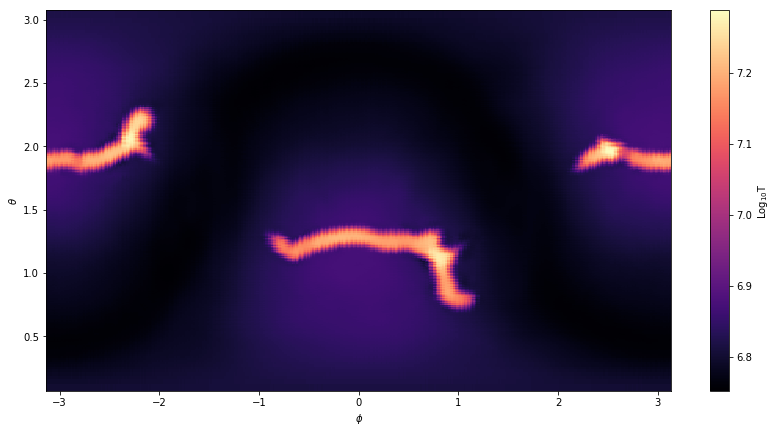

In [12]:
fig = plt.figure(figsize = (14,7))
ax = plt.subplot()
h = everywhere
z = h._cellParamVecs[:,:,0]
patches = plt.pcolormesh(h._phi,
                        h._theta,
                        z,
                         vmin = np.min(z),
                         vmax = np.max(z),
                         cmap = cm.magma,
                         linewidth = 1.0,
                         rasterized = True)
plt.colorbar(label='Log$_{10}$T')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')
print(np.min(z),np.max(z))

##### 3D Plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

fig = plt.figure(figsize = (14,7))

za = everywhere._cellParamVecs[:,:,0]

norm = Normalize(vmin = np.min(za),vmax=np.max(za))
cmap = cm.jet
fc = cmap(norm(za))
ax = fig.add_subplot(111, projection='3d')
radius = 4.0
X = radius*np.sin(everywhere._theta)*np.cos(everywhere._phi)
Y = radius*np.sin(everywhere._theta)*np.sin(everywhere._phi)
Z = radius*np.cos(everywhere._theta)
surf = ax.plot_surface(X,Y,Z,rstride=1,cstride=1,facecolors=fc, linewidth=1,shade=False) 
#surf = ax.plot_surface(everywhere._theta,everywhere._phi,za,facecolors = fc)
a = np.array( [1, 0, 1])

#Creates colorbar
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(a)
plt.colorbar(m)
#print(plt.cm.magma(za))
print(np.sqrt(np.min(X**2 + Y**2 + Z**2)),np.sqrt(np.max(X**2 + Y**2 + Z**2)))

#### Plot the pulse

The energy is 0.0309132837461 KeV or 4.9461253993760005e-11 ergs
 The frequency is 7464610252450159.0
(1, 1, 3, 100) (3,)


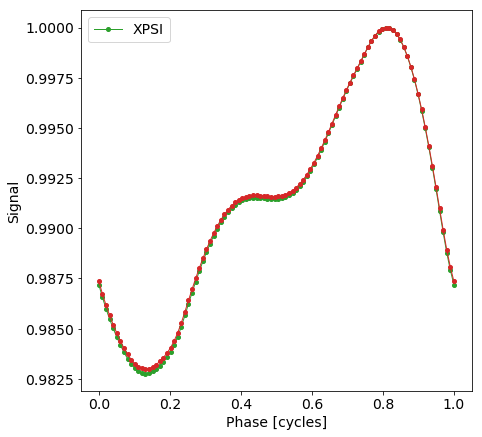

In [13]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

filename = "xpsi_pulse_data/energy_cgs/r4p2_oblate.txt"
sourceFile = open(filename, "w")
print("#Signal[photons/cm/s/keV]", "Phase", "Energy", file = sourceFile)
sourceFile.close()

def plot_pulse():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Signal')
    ax.set_xlabel('Phase [cycles]')

    temp = np.sum(photosphere.signal[0][0], axis=0)
    h = 6.6261e-27
    ind = 2
    print("The energy is", energies[ind], "KeV or", energies[ind]*1.60e-9,"ergs\n","The frequency is", energies[ind]*1.60e-9/h)
    ax.plot(everywhere.phases_in_cycles, photosphere.signal[0][0][ind]/np.max(photosphere.signal[0][0][ind]), 'o-', color='tab:green', lw=1.0, markersize=4,label='XPSI')
    ax.plot(everywhere.phases_in_cycles, photosphere.signal[0][0][0]/np.max(photosphere.signal[0][0][0]), 'o-', color='tab:red', lw=1.0, markersize=4)    
    sourceFile = open(filename, "a")
    for i in range(len(photosphere.signal[0][0][ind])):
        print(photosphere.signal[0][0][ind][i], everywhere.phases_in_cycles[i], energies[ind], file = sourceFile)
    sourceFile.close()
    print(np.shape(photosphere.signal),np.shape(energies))
    ax.legend()
_ = plot_pulse()

In [20]:
rcParams['text.usetex'] = False
rcParams['font.size'] = 14.0

def veneer(x, y, axes, lw=1.0, length=8, yticks=None):
    """ Make the plots a little more aesthetically pleasing. """
    if x is not None:
        if x[1] is not None:
            axes.xaxis.set_major_locator(MultipleLocator(x[1]))
        if x[0] is not None:
            axes.xaxis.set_minor_locator(MultipleLocator(x[0]))
    else:
        axes.xaxis.set_major_locator(AutoLocator())
        axes.xaxis.set_minor_locator(AutoMinorLocator())

    if y is not None:
        if y[1] is not None:
            axes.yaxis.set_major_locator(MultipleLocator(y[1]))
        if y[0] is not None:
            axes.yaxis.set_minor_locator(MultipleLocator(y[0]))
    else:
        axes.yaxis.set_major_locator(AutoLocator())
        axes.yaxis.set_minor_locator(AutoMinorLocator())

    axes.tick_params(which='major', colors='black', length=length, width=lw)
    axes.tick_params(which='minor', colors='black', length=int(length/2), width=lw)
    plt.setp(axes.spines.values(), linewidth=lw, color='black')

    if yticks:
        axes.set_yticks(yticks)

6.373456940247162e+38 6.264219610850332e+38 (1, 1, 3, 100)
0.00864378265697453


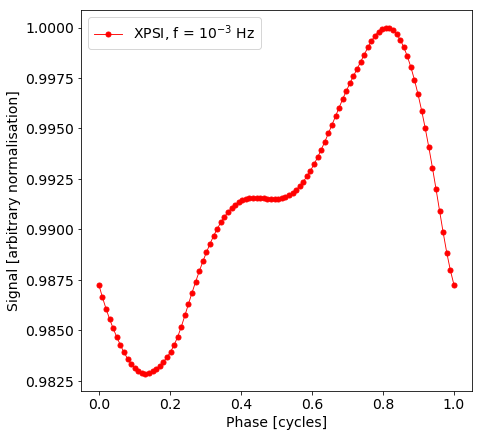

In [24]:
def plot_pulse():
    """ Plot hot region signals before telescope operation. """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)

    ax.set_ylabel('Signal [arbitrary normalisation]')
    ax.set_xlabel('Phase [cycles]')

    temp = np.sum(photosphere.signal[0][0], axis=0)
    print(max(temp),min(temp),np.shape(photosphere.signal))
    print((max(temp) - min(temp))/(max(temp) + min(temp)))
    ax.plot(everywhere.phases_in_cycles, temp/np.max(temp), 'o-', color='r', lw=0.9, markersize=5,label=r'XPSI, f = $10^{-3}$ Hz')
    ax.legend()
_ = plot_pulse()

#### Plot the 2D Pulse

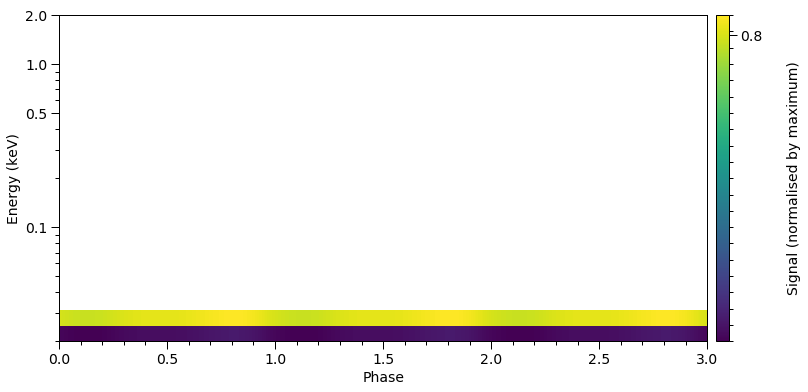

In [21]:
from xpsi.tools import phase_interpolator
def plot_2D_pulse(z, x, shift, y, ylabel,
                  num_rotations=3.0, res=5000, figsize=(12,6),
                  cm=cm.viridis,
                  yticks=None):
    """ Helper function to plot a phase-energy pulse.

    :param array-like z:
        A pair of *ndarray[m,n]* objects representing the signal at
        *n* phases and *m* values of an energy variable.

    :param ndarray[n] x: Phases the signal is resolved at.

    :param tuple shift: Hot region phase parameters.

    :param ndarray[m] x: Energy values the signal is resolved at.

    """

    fig = plt.figure(figsize = figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[50,1], wspace=0.025)
    ax = plt.subplot(gs[0])
    ax_cb = plt.subplot(gs[1])

    new_phases = np.linspace(0.0, num_rotations, res)

    interpolated = phase_interpolator(new_phases,
                                      x,
                                      z[0], shift[0])
    interpolated += phase_interpolator(new_phases,
                                       x,
                                       z[1], shift[1])

    profile = ax.pcolormesh(new_phases,
                             y,
                             interpolated/np.max(interpolated),
                             cmap = cm,
                             linewidth = 0,
                             rasterized = True)

    profile.set_edgecolor('face')

    ax.set_xlim([0.0, num_rotations])
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'Phase')
    veneer((0.1, 0.5), (None,None), ax, yticks=yticks)
    if yticks is not None:
        ax.set_yticklabels(yticks)

    cb = plt.colorbar(profile,
                      cax = ax_cb,
                      ticks = MultipleLocator(0.2))

    cb.set_label(label=r'Signal (normalised by maximum)', labelpad=25)
    cb.solids.set_edgecolor('face')

    veneer((None, None), (0.05, None), ax_cb)
    cb.outline.set_linewidth(1.0)

plot_2D_pulse((photosphere.signal[0][0], photosphere.signal[0][0]),
              x=everywhere.phases_in_cycles,
              shift=[0,0],
              y=energies,
              ylabel=r'Energy (keV)',
              yticks=[0.1, 0.5,1.0,2.0])


In [ ]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

In [ ]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5), # select energy indexes
                  'num_levels': 500,
                  'colormap': cm.Purples_r,
                  'phase_average': True,
                  'annotate_energies': True,
                  'energy_annotation_format': '[%.2f keV]',
                  'annotate_location': (0.025,0.025)} # do not phase average if you want to animate a sequence

In [ ]:
photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 800,
                  threads = 20,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12,
                  cache_intensities = False,
                  sky_map_kwargs = sky_map_kwargs) #

In [ ]:
# shape into (elliptical) rings and (quasi-linear) spokes
x = photosphere.images[1][1:].reshape(800,800)
y = photosphere.images[2][1:].reshape(800,800)

x_origin = photosphere.images[1][0]
y_origin = photosphere.images[2][0]

In [ ]:
photosphere.images

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.scatter(x_origin, y_origin, color='k', marker='+')
 # stride through rings and spokes
plt.scatter(x[::8,::8], y[::8,::8], s=0.1, color='k', marker='.')
plt.plot(x[-1,:], y[-1,:], color='k', linewidth=0.5)

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

In [ ]:
photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 800,
                  threads = 20,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12,
                  cache_intensities = 2.0,
                  sky_map_kwargs = sky_map_kwargs) #

In [ ]:
fig = plt.figure(figsize=(10,10))

plt.tricontour(photosphere.images[1],
               photosphere.images[2],
               photosphere.images[3],
               levels=np.linspace(0.1, math.pi-0.1, 50),
               colors='k',
               linestyles='solid',
               linewidths=0.25)

phi = np.copy(photosphere.images[4][...])

for i in range(len(phi)):
    # rays that scatter have negative constant values <-100
    # for quantities such as the azimuth
    if phi[i] > -100.0:
        if phi[i] > math.pi:
            while phi[i] > math.pi:
                phi[i] -= 2.0 * math.pi
        elif phi[i] < -math.pi:
            while phi[i] < -math.pi:
                phi[i] += 2.0 * math.pi

phi_lvls = np.linspace(np.min(phi[phi > -100.0]),
                       np.max(phi[phi > -100.0]), 100)
                
plt.tricontour(photosphere.images[1], # x
               photosphere.images[2], # y
               phi,
               levels = phi_lvls,
               linestyles = 'solid',
               linewidths = 0.25,
               extend = 'neither',
               colors='k')

intensity = photosphere.images[-1][0,0,:]

lvls = np.linspace(np.min(intensity[intensity > 0.0]),
                   np.max(intensity), 200)

plt.tricontourf(photosphere.images[1],
                photosphere.images[2],
                intensity,
                levels=lvls)

# overplot the ray pattern
plt.scatter(x_origin, y_origin, color='k', marker='+')
plt.scatter(x[::4,::4], y[::4,::4],
            s=0.1, color='k', marker='.')

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
veneer((0.05,0.25), (0.05,0.25), ax)

In [ ]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5), # select energy indexes
                  'num_levels': 500,
                  'colormap': cm.Purples_r,
                  'phase_average': True,
                  'annotate_energies': True,
                  'energy_annotation_format': '[%.2f keV]',
                  'annotate_location': (0.025,0.025)} # do not phase average if you want to animate a sequence

In [ ]:
photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 800,
                  threads = 20,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12,
                  cache_intensities = 2.0,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs)

#photosphere.image(reimage = False,
#                  energies = energies,
#                  phases = everywhere.phases_in_cycles * _2pi,
#                 plot_sky_maps = True,
#                  sky_map_kwargs = sky_map_kwargs,
#                  animate_sky_maps = False,
#                  animate_kwargs = {})
#photosphere.image(reimage = True,
#                  cache_intensities = 1.0, # cache size limit in GBs
#                  energies = energies,
#                  num_phases=800,
#                  phases = everywhere.phases_in_cycles * _2pi,
#                  sqrt_num_rays = 400,
#                  threads = 18,
#                  max_steps = 100000,
#                  epsrel_ray = 1.0e-12,
#                  plot_sky_maps = True, # activate if you want to plot frames
#                  sky_map_kwargs = sky_map_kwargs,
#                  animate_sky_maps = False)

photosphere.image(reimage = True,
                  reuse_ray_map = False,
                  energies = np.array([0.01,0.05,0.1]),
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 800,
                  threads = 20,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12,
                  cache_intensities = 1.0,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs) #

In [ ]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5),
                  'num_levels': 100, # in intensity field rendering
                  'colormap': cm.Purples_r,   # a colormap like this will make the lowest finite
                  'phase_average': False,     # intensity distinct from the black zero-intensity
                  'annotate_energies': True,  # background from the surface and behind the star
                  'energy_annotation_format': '[%.2f keV]',
                  'annotate_location': (0.025,0.025)}

animate_kwargs = {'cycles': 8, 'fps': 32}
    
photosphere.image(reimage = True,
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 200,
                  threads = 18,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True, # activate if you want to plot frames
                  sky_map_kwargs = sky_map_kwargs,
                  animate_sky_maps = False)

In [ ]:
np.log10(1.e15)

In [ ]:
from scipy.constants import h,k,c

def blackbody_lam(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    lam = 1e-9 * lam # convert to metres
    return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

wa1 = np.linspace(0.1, 4, 10)   # wavelengths in nm
wa2 = np.linspace(0.1, 3.e2, 100)   # wavelengths in nm
T1 = 1.e7
T2 = 1.e5
#Lets transform nm to energy in keV
#Transform nm to m
energy1 = (h * c/(wa1 * 1.e-9) ) * 6.242e18/1.e3 #keV
energy2 = (h * c/(wa2 * 1.e-9) ) * 6.242e18/1.e3 #keV


plt.figure()
plt.plot(wa1,blackbody_lam(wa1,T1))
plt.figure()
plt.plot(energy2,blackbody_lam(wa2,T2))


In [ ]:
import numpy as np

theta = np.linspace(0,np.pi,5)
phi = np.linspace(-np.pi,np.pi,10)
ph,th = np.meshgrid(phi,theta)
print(th[:,1],ph[1,:])
x = np.searchsorted(th[:,1], 1.8,side='left')
y = np.searchsorted(ph[x,:], 1.8,side='left')

print(x,y)
print(th[x,y],ph[x,y])
print(ph[x,y-1],ph[x,y],th[x-1,y],th[x,y])
#print(th)
#print(th[1][1],ph[1][1])
#print(th[1][2],ph[1][2])

#print(th[2][1],ph[2][1])
#print(th[2][2],ph[2][2])

#print(th[1,1],ph[1,1],th[2,1],ph[2,1])
#print(th[1,2],ph[1,2],th[2,2],ph[2,2])
#print(256/2)
d = np.zeros((5,5,1))
d[:,:,0] = 5
p = np.zeros((5,5))
p[:,:] = 10
d[...,:-1] = 5
#print(d[...,:])
#print(d[:,:,0].shape)